<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Bolometer_Calorimetric_Readout_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

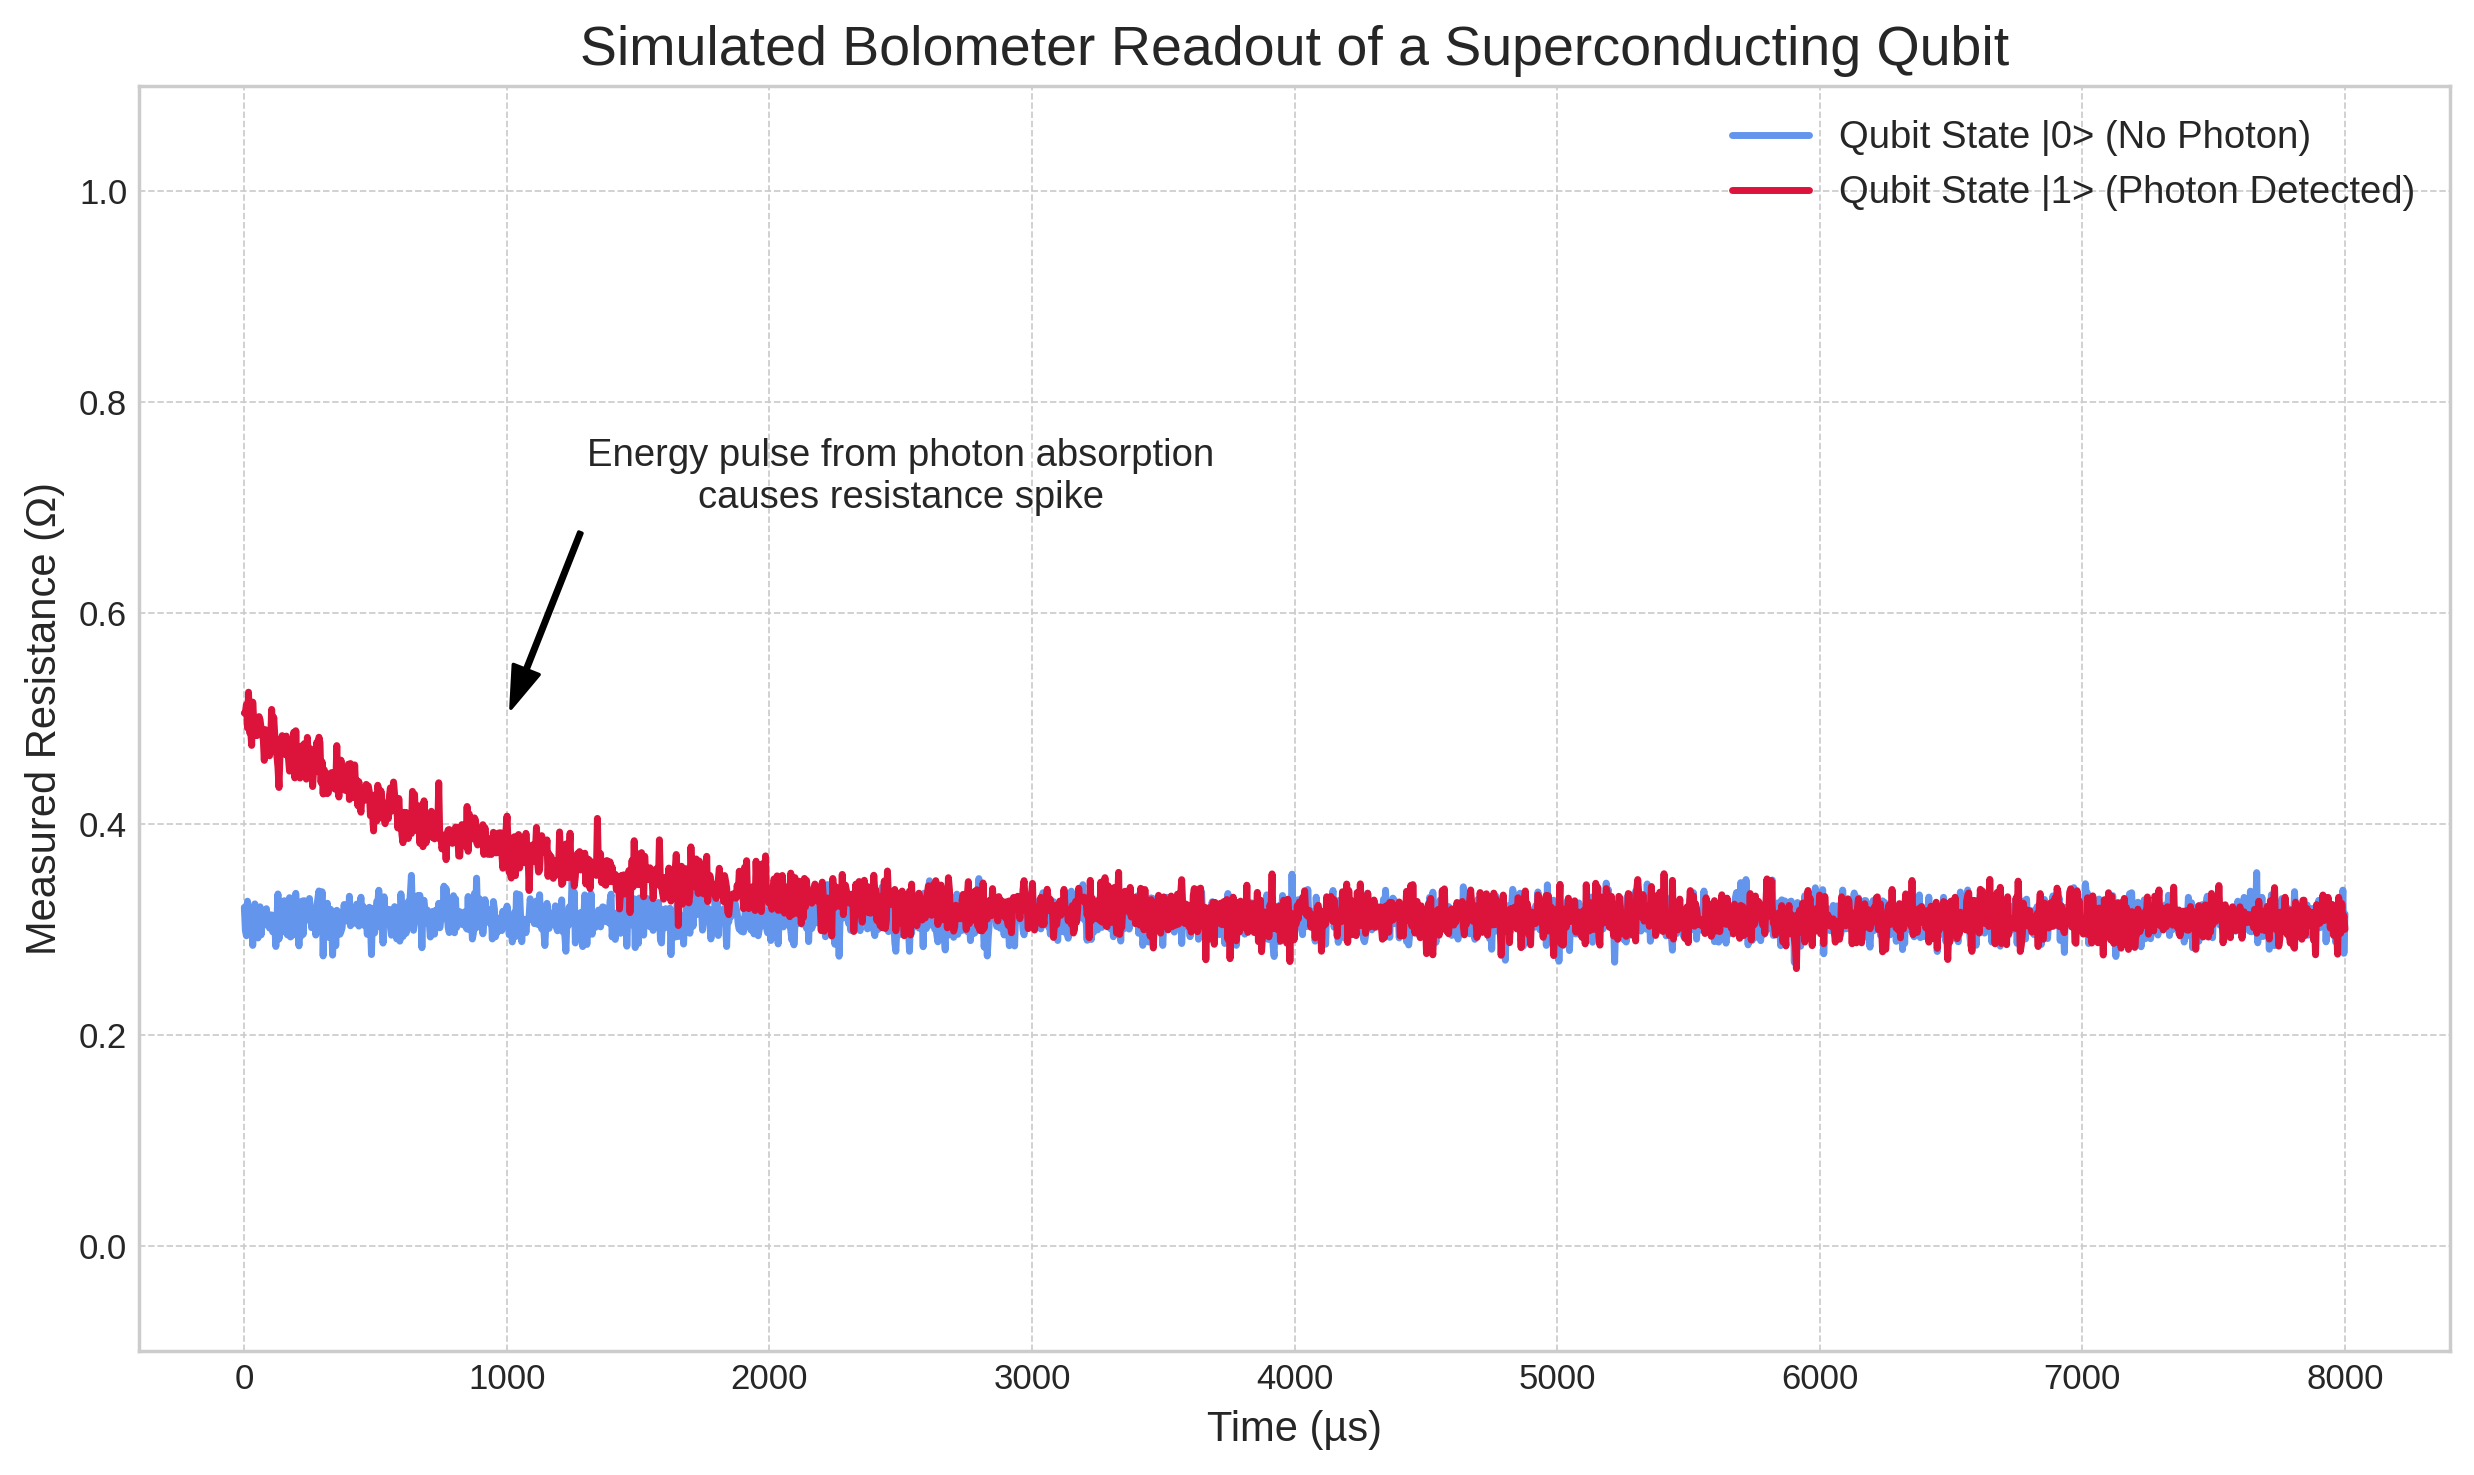

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Physical Parameters for the Simulation ---

# Bolometer (TES) Properties
T_c = 100e-3      # Superconducting critical temperature (100 mK)
# CHANGED: Bias the bolometer onto the transition edge for sensitivity
T_base = 98e-3    # Base temperature of the cold bath (98 mK)
R_n = 1.0         # Normal state resistance (1 Ohm)
C = 0.1e-12       # Heat capacity of the bolometer (0.1 pJ/K)
G = 100e-12       # Thermal conductance to the bath (100 pW/K)
tau = C / G       # Thermal time constant

# Qubit and Signal Properties
# CHANGED: Increased pulse energy for a more visible signal
E_pulse = 0.2e-15 # Energy of the amplified microwave pulse from |1> state (0.2 fJ)

# Simulation Parameters
t_max = 8 * tau   # Simulate for 8 thermal time constants
n_points = 2000   # Number of points in the simulation
time = np.linspace(0, t_max, n_points)

# Noise Parameters
temp_noise_std = 0.1e-3  # Temperature noise std deviation (0.1 mK)
readout_noise_std = 0.01 * R_n # Readout noise std deviation

# --- TES Resistance Model ---
def tes_resistance(T):
    """
    Models the TES resistance vs. temperature using a hyperbolic tangent.
    This creates the sharp transition from superconducting (R=0) to normal (R=Rn).
    """
    transition_width = 5e-3 # Width of the superconducting transition (5 mK)
    return R_n / 2 * (1 + np.tanh((T - T_c) / transition_width))

# --- Main Simulation Function ---
def simulate_readout(qubit_state):
    """
    Simulates the bolometer's response to a qubit readout.
    Returns the resistance signal over time.
    """
    # 1. Determine the energy deposited based on qubit state
    energy_deposited = E_pulse if qubit_state == 1 else 0.0

    # 2. Calculate the initial temperature change
    delta_T_initial = energy_deposited / C

    # 3. Model the temperature decay over time
    # T(t) = T_base + Delta_T * exp(-t/tau) + noise
    temp_decay = delta_T_initial * np.exp(-time / tau)
    thermal_noise = np.random.normal(0, temp_noise_std, n_points)
    temperature_over_time = T_base + temp_decay + thermal_noise

    # 4. Calculate the corresponding resistance signal
    resistance_signal = tes_resistance(temperature_over_time)

    # 5. Add readout circuit noise
    readout_noise = np.random.normal(0, readout_noise_std, n_points)
    final_signal = resistance_signal + readout_noise

    return final_signal

# --- Run Simulation and Plot Results ---

# Set a professional plot style
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6), dpi=250)

# Simulate for both qubit states
signal_from_0 = simulate_readout(qubit_state=0)
signal_from_1 = simulate_readout(qubit_state=1)

# Plot the results
ax.plot(time * 1e6, signal_from_0, label='Qubit State |0> (No Photon)', color='cornflowerblue', linewidth=2)
ax.plot(time * 1e6, signal_from_1, label='Qubit State |1> (Photon Detected)', color='crimson', linewidth=2)

# Formatting the plot
ax.set_title('Simulated Bolometer Readout of a Superconducting Qubit', fontsize=16)
ax.set_xlabel('Time (µs)', fontsize=12)
ax.set_ylabel('Measured Resistance (Ω)', fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim(-0.1, R_n * 1.1)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add an annotation for clarity
ax.annotate('Energy pulse from photon absorption\ncauses resistance spike',
            xy=(tau * 1e6, 0.5),
            xytext=(tau * 2.5e6, 0.7),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
            fontsize=11, ha='center')

plt.tight_layout()
plt.show()